## Provide Kaggle Credentials

In [2]:
# Access google colab file system
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


## Download Dataset

In [3]:
# Download kaggle dataset
!kaggle datasets download paultimothymooney/chest-xray-pneumonia 

 99% 1.14G/1.15G [00:11<00:00, 94.4MB/s]
100% 1.15G/1.15G [00:11<00:00, 105MB/s] 


In [4]:
!unzip chest-xray-pneumonia.zip
!unzip chest_xray.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          
Archive:  chest_xray.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
   creating: __MACOSX/chest_xray/test/PNEUMONIA/
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person78_bacteria_382.jpeg  
  inflating: chest_xray/test/PNEUMONIA/

## Import necessary libraries

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

import time
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


In [6]:
tf.__version__

'2.0.0-rc1'

## Setup Input Pipeline

In [0]:
base_dir = '/content/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

Use `ImageDataGenerator` to rescale the images.

Create the train generator and specify where the train dataset directory, image size, batch size.

Create the validation generator with similar approach as the train generator with the flow_from_directory() method.

In [8]:
IMAGE_SIZE = 150
BATCH_SIZE = 163
class_mode='categorical'

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
#     batch_size=sum([len(files) for r, d, files in os.walk(train_dir)]),
    class_mode=class_mode)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
#     batch_size=sum([len(files) for r, d, files in os.walk(val_dir)]),
    class_mode=class_mode)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
#     batch_size=sum([len(files) for r, d, files in os.walk(test_dir)]),
    class_mode=class_mode)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((163, 150, 150, 3), (163, 2))

In [0]:
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

In [11]:
class_weight = get_weight(train_generator.classes)
class_weight

array([1.9448173 , 0.67303226])

Save the labels in a file which will be downloaded later.

In [12]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [13]:
!cat labels.txt

NORMAL
PNEUMONIA

## Create the base model from the pre-trained convnets


In [0]:
model_file = "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

In [15]:

checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)


tensorboard = TensorBoard(
    log_dir=time.strftime('%Y-%m-%d %H-%M-%S'),
    batch_size=BATCH_SIZE,
    update_freq = 'batch')


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)


#-----------------------------------------------------------------------------------------------------------------#
callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]
# callbacks = [checkpoint, tensorboard]
#-----------------------------------------------------------------------------------------------------------------#
print("Set Callbacks at ")

Set Callbacks at 


In [16]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

base_model.summary()

87916544/87910968 [==============================] - 8s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________

## Feature extraction
You will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

In [0]:
base_model.trainable = False

### Add a classification head

In [0]:
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

predictions = tf.keras.layers.Dense(2, activation='sigmoid')(x) 

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

### Compile the model

You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss.

In [0]:
# model.compile(optimizer=tf.keras.optimizers.Adam(), 
#               loss='categorical_crossentropy', 
#               metrics=['accuracy'])

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [22]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 8


### Train the model

<!-- TODO(markdaoust): delete steps_per_epoch in TensorFlow r1.14/r2.0 -->

In [23]:
epochs = 10

history = model.fit_generator(train_generator, 
                    epochs=epochs, 
                    validation_data=val_generator,
                    verbose=1)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
32/32 [==============================] - 75s 2s/step - loss: 0.5302 - accuracy: 0.7655 - val_loss: 0.7133 - val_accuracy: 0.6250
Epoch 2/10
32/32 [==============================] - 71s 2s/step - loss: 0.3865 - accuracy: 0.8386 - val_loss: 1.4510 - val_accuracy: 0.5000
Epoch 3/10
32/32 [==============================] - 71s 2s/step - loss: 0.3289 - accuracy: 0.8631 - val_loss: 1.2011 - val_accuracy: 0.8125
Epoch 4/10
32/32 [==============================] - 71s 2s/step - loss: 0.2928 - accuracy: 0.8832 - val_loss: 1.6947 - val_accuracy: 0.6250
Epoch 5/10
32/32 [==============================] - 72s 2s/step - loss: 0.2710 - accuracy: 0.8909 - val_loss: 1.8237 - val_accuracy: 0.6250
Epoch 6/10
32/32 [==============================] - 72s 2s/step - loss: 0.2504 - accuracy: 0.8980 - val_loss: 1.0200 - val_accuracy: 0.5625
Epoch 7/10
32/32 [==============================] - 72s 2s/step - 

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the Inception V3 base model as a fixed feature extractor. 

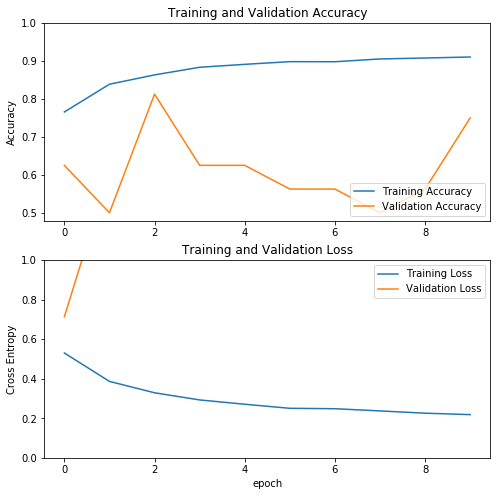

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning


### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers be un-trainable. Then, recompile the model (necessary for these changes to take effect), and resume training.

In [0]:
base_model.trainable = True

In [26]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  311


### Compile the model

Compile the model using a much lower training rate.

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [29]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 136


### Continue Train the model

In [30]:
history_fine = model.fit_generator(train_generator, 
                         epochs=5,
                         validation_data=val_generator)

Epoch 1/5
32/32 [==============================] - 75s 2s/step - loss: 0.1975 - accuracy: 0.9210 - val_loss: 2.6396 - val_accuracy: 0.4375
Epoch 2/5
32/32 [==============================] - 72s 2s/step - loss: 0.1741 - accuracy: 0.9310 - val_loss: 1.4599 - val_accuracy: 0.7500
Epoch 3/5
32/32 [==============================] - 72s 2s/step - loss: 0.1631 - accuracy: 0.9375 - val_loss: 1.2751 - val_accuracy: 0.8125
Epoch 4/5
32/32 [==============================] - 72s 2s/step - loss: 0.1369 - accuracy: 0.9496 - val_loss: 2.2038 - val_accuracy: 0.5625
Epoch 5/5
32/32 [==============================] - 72s 2s/step - loss: 0.1373 - accuracy: 0.9471 - val_loss: 1.2936 - val_accuracy: 0.6250


## Convert to TFLite

Saved the model using `tf.saved_model.save` and then convert the saved model to a tf lite compatible format.

In [31]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/fine_tuning/assets


Download the converted model and labels

In [32]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 51218, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

Let's take a look at the learning curves of the training and validation accuracy/loss, when fine tuning the last few layers of the InceptionV3 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.


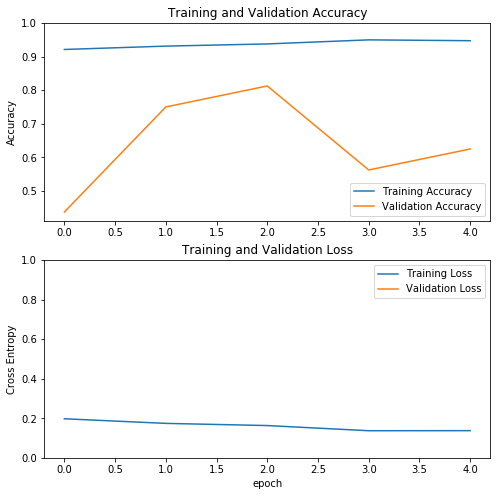

In [33]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluate against test data

In [34]:
# Run the model on Test Data 
result = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

4/4 [==============================] - 10s 2s/step - loss: 1.3201 - accuracy: 0.6891
Loss     : 1.32  
Accuracy : 68.91%


In [0]:
def compare_results(root_path, generator):

  predictions = model.predict_generator(generator) # Return numpy array of predictions
  class_predicted= [np.argmax(prediction) for prediction in predictions]
  fig = plt.figure(figsize=(24, 18))
  fig.subplots_adjust(hspace=1.5)
  
  normal_path = root_path + '/NORMAL/'
  pneumonia_path = root_path + '/PNEUMONIA/'
  
  normal_dir = os.listdir(normal_path)
  pneumonia_dir = os.listdir(pneumonia_path)
  
  # Generators
  normal_gen =  (x for x in normal_dir if x.endswith('.jpeg'))
  pneumonia_gen =  (y for y in pneumonia_dir if y.endswith('.jpeg'))
  
  for i, normal_file in enumerate(normal_gen):
    img = plt.imread(normal_path + normal_file)
    plt.subplot(4, 4, 1 + i)
    plt.title(f"Prediction: NORMAL\nTrue value: NORMAL" if class_predicted[i] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: NORMAL")
    plt.imshow(img)
    
  for j, pneumonia_file in enumerate(pneumonia_gen):
    img = plt.imread(pneumonia_path + pneumonia_file)
    plt.subplot(4, 4, 9 + j)
    plt.title(f"Prediction: NORMAL\nTrue value: PNEUMONIA" if class_predicted[8+j] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: PNEUMONIA")
    plt.imshow(img)

0
1
2
3
4
5
6
7


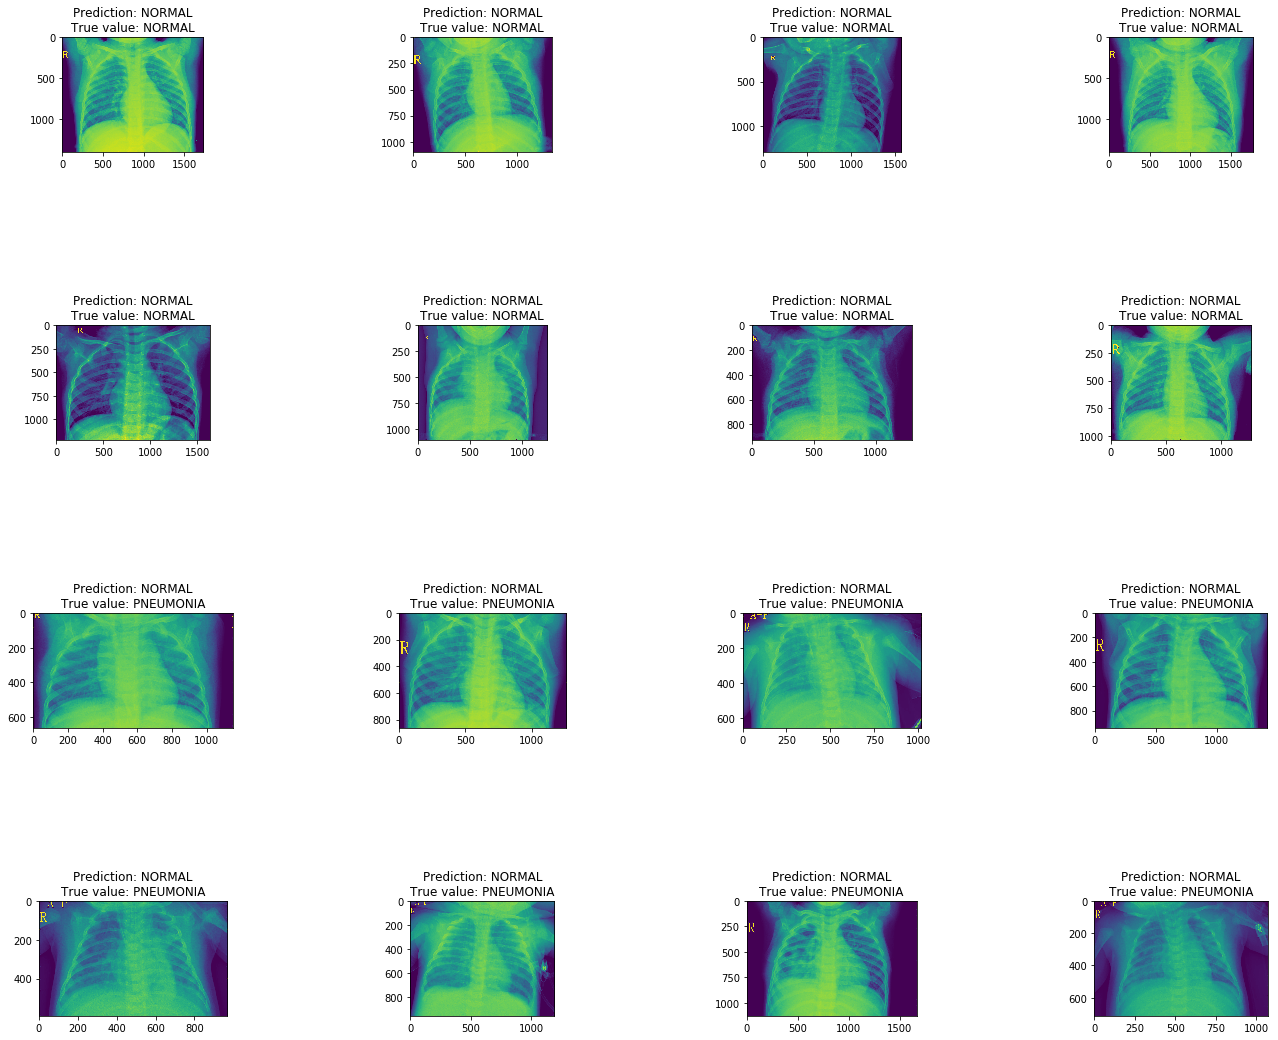

In [45]:
compare_results(val_dir, val_generator)